# DDPM

I will be implementing the Denoising Diffusion Probabilistic Model from the paper with the same name by Ho et al. (2020)
Generation will be on MNIST.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.nn.init as init


## The model

Taken from https://github.com/zoubohao/DenoisingDiffusionProbabilityModel-ddpm-/blob/main/Diffusion/Model.py

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

In [9]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / d_model * np.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            Swish(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h


class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(1, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 1, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

In [8]:
def gather_reshape(v, t, x_shape):
    """
    :param v: tensor of parameters (such as beta)
    :param t: tensor of indices, for each element in batch has a corresponding index
    :param x_shape: shape of the output tensor (to easily find x_t)
    """
    out = torch.gather(v, index=t, dim=0).float().to(device)
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))

In [81]:
class DiffusionLoss(nn.Module):
    def __init__(self, T, model, beta_1, beta_T):
        super().__init__()
        self.T = T
        self.model = model
        self.register_buffer('beta', torch.linspace(beta_1, beta_T, T))
        a = 1 - self.beta
        alpha = torch.cumprod(a, 0)
        self.register_buffer('sqrt_alpha', alpha.sqrt())
        self.register_buffer('sqrt_1m_alpha', (1 - alpha).sqrt())

    def forward(self, train_x):
        B, C, H, W = train_x.shape
        t = torch.randint(self.T, (B, )).to(device)  # time index is uniform (int)
        noise = torch.randn_like(train_x).to(device)  # epsilon
        x_t = gather_reshape(self.sqrt_alpha, t, train_x.shape) * train_x + gather_reshape(self.sqrt_1m_alpha, t, train_x.shape) * noise  # according to equation
        loss = F.mse_loss(self.model(x_t, t), noise)
        return loss

In [13]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [60]:
model = UNet(T=1000, ch=32, ch_mult=(1, 2), attn=(), num_res_blocks=2, dropout=0.1).to(device)
model = nn.DataParallel(model)
loss_fn = DiffusionLoss(T=1000, model=model, beta_1=0.0001, beta_T=0.02).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
import matplotlib.pyplot as plt

In [20]:
class DiffusionSampler(nn.Module):
    def __init__(self, T, model, beta_1, beta_T):
        super().__init__()
        self.T = T
        self.model = model
        self.register_buffer('beta', torch.linspace(beta_1, beta_T, T))
        a = 1 - self.beta
        alpha = torch.cumprod(a, 0)
        alpha_padded = F.pad(alpha, [1, 0], value=1)[:T]
        self.register_buffer('coeff_prev', 1 / a.sqrt())
        self.register_buffer('coeff_noise', self.coeff_prev * (1 - a) / (1 - alpha).sqrt())
        self.register_buffer('posterior_var', self.beta * (1. - alpha_padded) / (1. - alpha))
        self.register_buffer('variance', torch.cat([self.posterior_var[1:2], self.beta[1:]]))


    def forward(self, x):
        for time in reversed(range(self.T)):
            if time == 0:
                noise = 0
            else:
                noise = torch.randn_like(x)
            t = x.new_ones(x.shape[0], dtype=int) * time
            mean = gather_reshape(self.coeff_prev, t, x.shape) * x - gather_reshape(self.coeff_noise, t, x.shape) * self.model(x, t)
            var = gather_reshape(self.variance, t, x.shape)
            x = mean + torch.sqrt(var) * noise
        return x
    
    def generate_visualize(self):
        x = torch.randn(4, 1, 28, 28).to(device)
        xs = [x.cpu().detach().numpy()]
        for time in reversed(range(self.T)):
            t = x.new_ones(x.shape[0], dtype=int) * time
            mean = gather_reshape(self.coeff_prev, t, x.shape) * x - gather_reshape(self.coeff_noise, t, x.shape) * self.model(x, t)
            var = gather_reshape(self.variance, t, x.shape)
            if time == 0:
                x = mean
            else:
                x = mean + torch.sqrt(var) * torch.randn_like(x)
            if time % (self.T // 10) == 0:
                xs.append(x.cpu().detach().numpy())
        return xs


In [2]:
import os
from typing import Dict

def train(modelConfig: Dict):
    device = torch.device(modelConfig["device"])
    # dataset
    # Define the transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load MNIST dataset
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # model setup
    net_model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
    if modelConfig["training_load_weight"] is not None:
        net_model.load_state_dict(torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["training_load_weight"]), map_location=device))
    optimizer = torch.optim.AdamW(
        net_model.parameters(), lr=modelConfig["lr"], weight_decay=1e-4)
    trainer = DiffusionLoss(
        modelConfig["T"], net_model, modelConfig["beta_1"], modelConfig["beta_T"]).to(device)
    
    if not os.path.exists(modelConfig["save_weight_dir"]):
        os.makedirs(modelConfig["save_weight_dir"])

    # start training
    for e in range(modelConfig["epoch"]):
        with tqdm(train_loader, dynamic_ncols=True) as tqdmDataLoader:
            for images, labels in tqdmDataLoader:
                # train
                optimizer.zero_grad()
                x_0 = images.to(device)
                loss = trainer(x_0)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    net_model.parameters(), modelConfig["grad_clip"])
                optimizer.step()
                tqdmDataLoader.set_postfix(ordered_dict={
                    "epoch": e,
                    "loss: ": loss.item(),
                    "img shape: ": x_0.shape,
                    "LR": optimizer.state_dict()['param_groups'][0]["lr"]
                })
        torch.save(net_model.state_dict(), os.path.join(
            modelConfig["save_weight_dir"], 'ckpt_' + str(e) + "_.pt"))

In [28]:
from torchvision.utils import save_image

def eval(modelConfig: Dict):
    # load model and evaluate
    with torch.no_grad():
        device = torch.device(modelConfig["device"])
        model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        ckpt = torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["test_load_weight"]), map_location=device, weights_only=True)
        model.load_state_dict(ckpt)
        model.eval()
        sampler = DiffusionSampler(
             modelConfig["T"], model, modelConfig["beta_1"], modelConfig["beta_T"]).to(device)
        # Sampled from standard normal distribution
        noisyImage = torch.randn(
            size=[modelConfig["batch_size"], 1, 28, 28], device=device)
        
        if modelConfig['show_process']:
            # showing diffusion process
            images = sampler.generate_visualize()
            num_steps = len(images)
            fig, axs = plt.subplots(4, num_steps, figsize=(3*num_steps, 12))
            for i, batch_imgs in enumerate(images):
                for j in range(4):  # Plot each image in the batch
                    img = batch_imgs[j, 0]  # Extract the j-th image in grayscale (1 channel)
                    axs[j, i].imshow(img, cmap='gray')
                    axs[j, i].axis('off')
                axs[0, i].set_title(f"Step {modelConfig['T'] - i * (modelConfig['T'] // 10)}")

            plt.tight_layout()
            plt.savefig('diffusion_process.png')
            plt.show()
        else:
        # generating final image:
            saveNoisy = torch.clamp(noisyImage, 0, 1)
            save_image(saveNoisy, os.path.join(
                modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])
            sampledImgs = sampler(noisyImage)
            save_image(sampledImgs, os.path.join(
                modelConfig["sampled_dir"],  modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])

In [17]:
modelConfig = {
        "state": "train",
        "epoch": 50,
        "batch_size": 64,
        "T": 1000,
        "channel": 32,
        "channel_mult": [1, 2],
        "attn": [],
        "num_res_blocks": 2,
        "dropout": 0.15,
        "lr": 5e-4,
        "multiplier": 2.,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 28,
        "grad_clip": 1.,
        "device": "cuda:0",
        "training_load_weight": None,
        "save_weight_dir": "./Checkpoints5/",
        "test_load_weight": "ckpt_49_.pt",
        "sampled_dir": "",
        "sampledNoisyImgName": "NoisyNoGuidenceImgs.png",
        "sampledImgName": "SampledNoGuidenceImgs.png",
        "nrow": 8,
        "show_process": True
        }



In [85]:
train(modelConfig)

100%|██████████| 938/938 [01:05<00:00, 14.27it/s, epoch=49, loss: =0.0149, img shape: =torch.Size([32, 1, 28, 28]), LR=0.0005] 


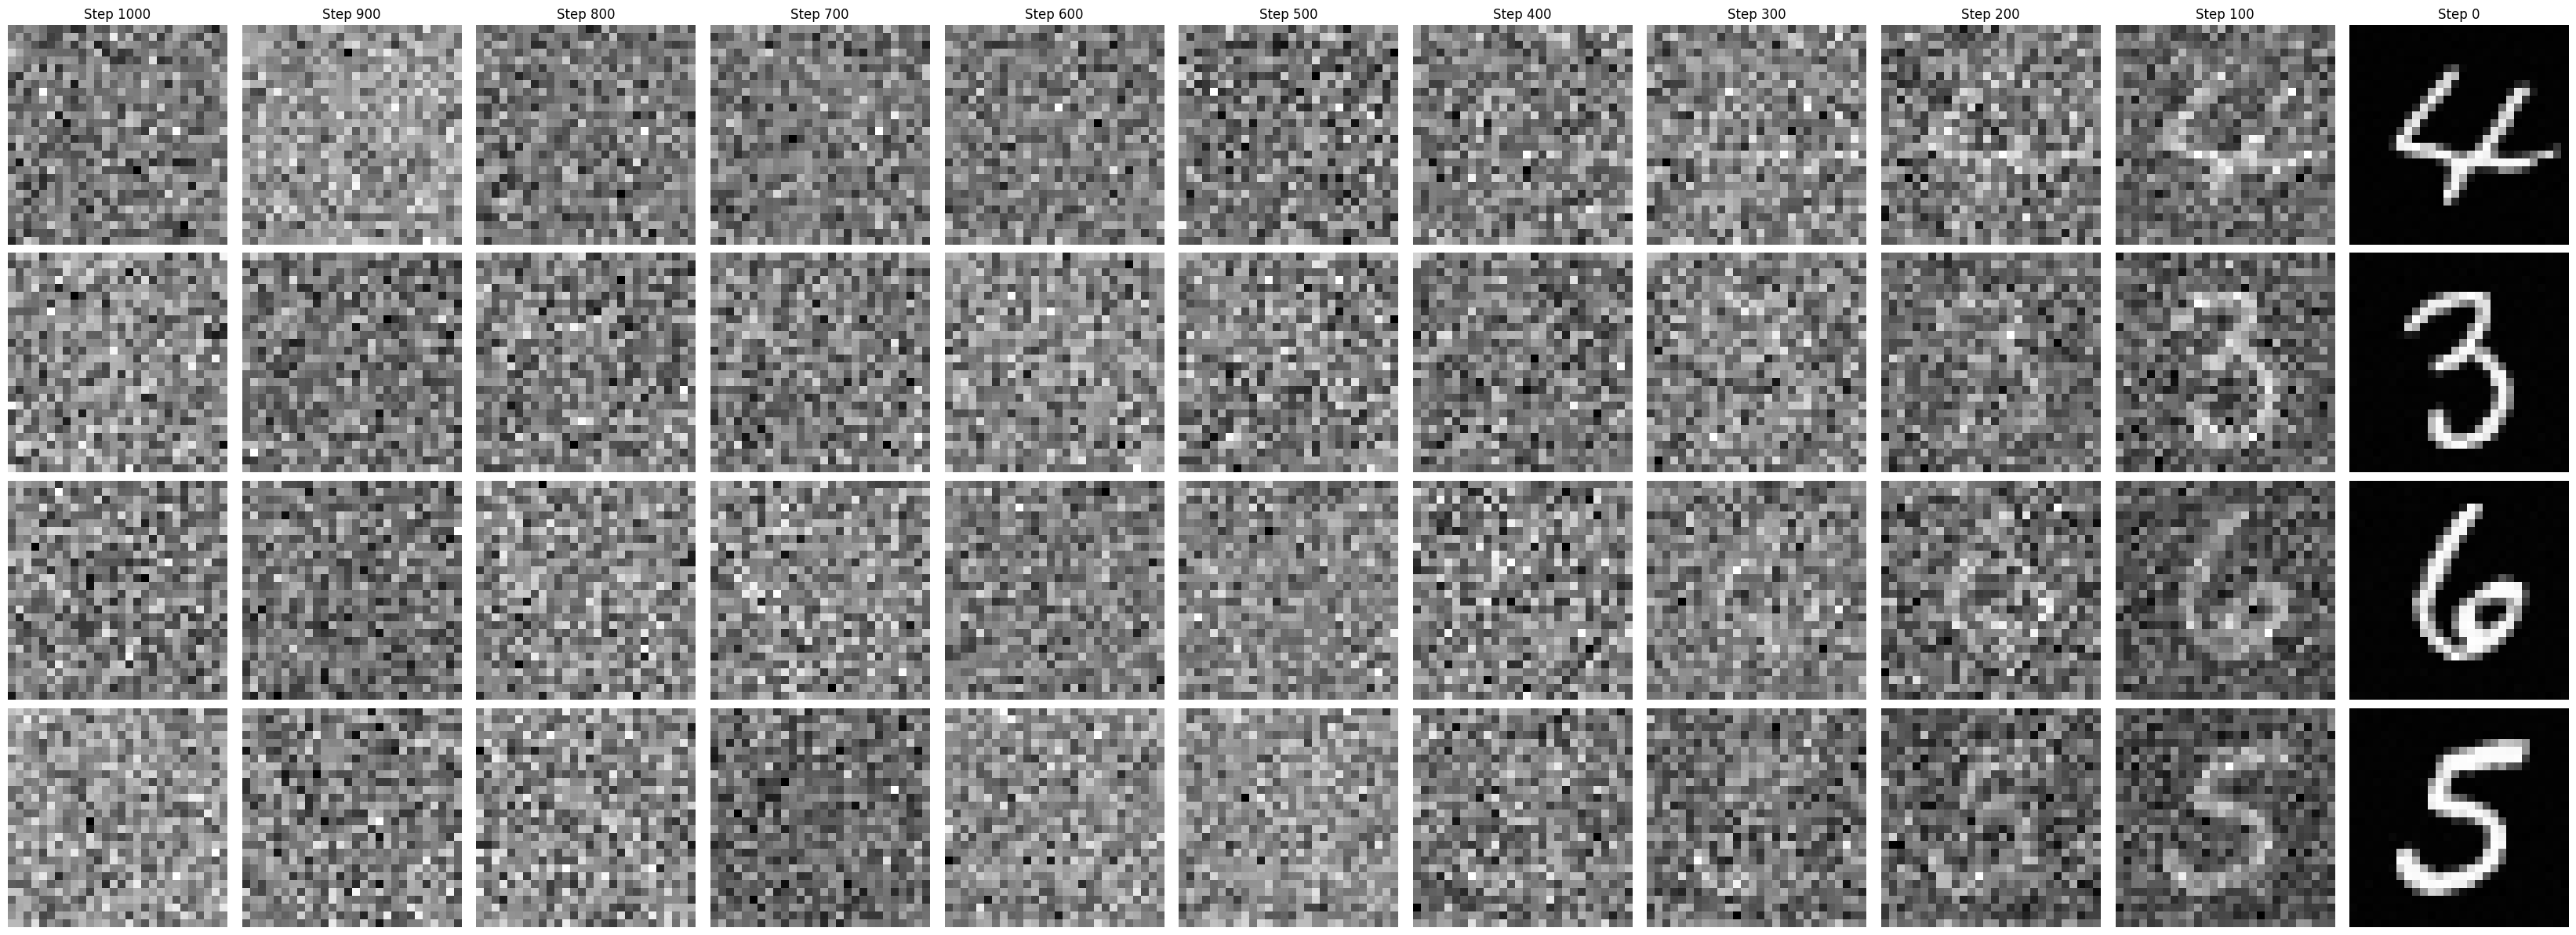

In [30]:
eval(modelConfig)